<div class="alert alert-block alert-info"><b>Opdatering:</b> I beregningen af $\chi^2$ har jeg for hhv. simulering og GRACE-data brugt afvigelsen fra middelværdien af de simulerede voluminer og volumenændringsdata (for at undgå favorisering af "halepunkter"). Tabellen nedenfor er opdateret. 
    
<b>Note:</b>
Jeg har kørt nedenstående kode for tre akkumulationskonstanter (svarende til middelnedbøren fra tabel 2 i https://tc.copernicus.org/articles/14/3935/2020/ og middelnedbøren hhv. plus og minus usikkerheden). Tabellen herunder viser de resulterende $\chi^2$ og $k_{melt}$. Optimeringen er kørt med en opløsning på 1000 punkter pr. $k_{melt}$-enhed og den tager mig ca. 5 min. at køre.</div>

|Årlig nedbør|minimalt $\chi^2$...|og den tilsvarende $k_{melt}$|
|:----------:|:---------------:|:---------------------------:|
|642-59 Gt|$1,14\cdot 10^5$|$5,296$|
|642 Gt   |$1,22\cdot 10^5$|$5,655$|
|642+59 Gt|$1,32\cdot 10^5$ |$6,015$|

Importerer pakker.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Indlæsning af DMI-data (data fra Ilulissat).

In [2]:
daily_Ilul = pd.read_excel('DailyMinMax_Ilullisat_Cor.xlsx')
Ilul = daily_Ilul.to_numpy()
time_Ilul = Ilul[:,0]
temp_Ilul = Ilul[:,1]
completeness_Ilul = Ilul[:,2]

Indlæsning af GRACE-data (satellit-data). I linje 2 udvælges GRACE-data indtil 2021 - det passer med det seneste tidspunkt, vi har DMI-data fra. I linje 6 omregnes masseændringen til en volumenændring. I linje 7 beregnes det samlede volumen af GrIS ud fra GRACE-volumenændringerne. Voluminet er korrigeret, så V er $2.85\cdot 10^{15}$ i 2021 (kilde?). I linje 8 beregnes usikkerheden på voluminet med ophobningsloven (mangler der evt. et usikkerhedsbidrag fra densiteten?).

In [3]:
grace = np.genfromtxt('greenland_mass_200204_202311.txt', delimiter='', skip_header=31)
grace = grace[grace[:,0]<=time_Ilul[-1]]

år_grace, masseændring_grace, error_grace = grace[:,0], grace[:,1], grace[:,2] 

volumenændring_grace = masseændring_grace*10**12/917  # m^3
v_grace = volumenændring_grace + 2.85*10**15 - volumenændring_grace[-1]
err_v_grace = abs(error_grace*10**(12)/917)   # Usikkerhed på GRACE-volumen, angivet i m^3.

Startbetingelser gives, og der simuleres bagud i tid.

In [4]:
R_0 = 500 * 10**3         # m, afstand fra midten af iskappen til randen
h_0 = 3 * 10**3           # m, GrIS-højde i dag
k_h = h_0/np.sqrt(R_0)    # antager, k_h er konstant (dvs. iskappens form ikke ændrer sig)

T_f = 0                   # deg C, vands frysepunkt
alfa = - 9.8 * 10**(-3)   # temperaturændring pr. højdeforøgelse (deg C/m)
dt = 1/(365.25*2)         # år

acc = 0.2                 # m/år, antaget konstant akkumulation (højdeændring)
k_acc = (642/0.917)/305.1 # akkumulationskonstant. Også prøvet: #((642-59)/0.917)/305.1 #((642+59)/0.917)/305.1

In [5]:
def simulering(k_melt):
    v_list = []
    v_meltlist = []
    v_acclist = []
    V = 2.85 * 10**15  # m^3, begyndelsesvolumen
    for i in range(len(time_Ilul)):
        R = (3/16 * V/k_h)**(2/5)
        if temp_Ilul[-i] - T_f <= 0:
            v_melt = 0
        else:
            v_melt =  k_melt * 8/3 * R * (temp_Ilul[-i]-T_f)**3/(alfa * k_h)**2 * dt
        v_acc = k_acc * acc * 8 * R**2 * dt # Nedbør på GrIS pr. halve døgn
        V += - v_acc + v_melt
    
        v_meltlist.append(v_melt)
        v_acclist.append(v_acc)
        v_list.append(V)
    
    # Interpolation
    v_inter_sim = np.interp(år_grace, time_Ilul[time_Ilul>=år_grace[0]], v_list[:len(time_Ilul[time_Ilul>=år_grace[0]])])
    
    # Gennemsnit
    v_grace_ny = v_grace-np.mean(v_grace)
    v_sim_ny = v_inter_sim-np.mean(v_inter_sim)
    #plt.plot(np.flip(år_grace), v_sim_ny)
    #plt.plot(år_grace, v_grace_ny)
    #plt.show()
    
    # Chikvadrat
    chi2 = np.sum(((v_sim_ny-np.flip(v_grace_ny))/np.flip(err_v_grace))**2)
    return chi2, v_list 

Så prøver vi at implementere optimering.

In [6]:
def optimering(gæt_start, gæt_slut, antal_forsøg):
    konstanter_list = np.linspace(gæt_start, gæt_slut, antal_forsøg)
    chi_list = []
    
    for i in konstanter_list:
        chi_list.append(simulering(i)[0])
    chi2 = min(chi_list)
    k_melt = konstanter_list[np.argmin(chi_list)]
    
    # Plotting
    plt.figure(figsize = (10,6))
    plt.errorbar(år_grace, v_grace, yerr = err_v_grace, fmt = '.', elinewidth = 1, label = 'GRACE-data')
    plt.plot(np.flip(time_Ilul), simulering(k_melt)[1], label = 'Simulering baglæns') # Tiden er vendt om, fordi volumensimuleringen er kørt fra nutid mod fortid.
    plt.xlim(2000,2022)
    plt.ylim(2.849*10**15, 2.857*10**15)
    plt.xlabel('Årstal (e.Kr.)', fontsize = 15)
    plt.ylabel('GIS-volumen', fontsize = 15)
    plt.title('GIS-volumen', fontsize = 18)
    plt.grid()
    plt.legend(fontsize = 12)
    plt.savefig(f'GIS_k_melt={k_melt}_k_acc={k_acc}.jpg', dpi = 300)
    plt.show()
    
    return konstanter_list, chi_list, k_melt, chi2

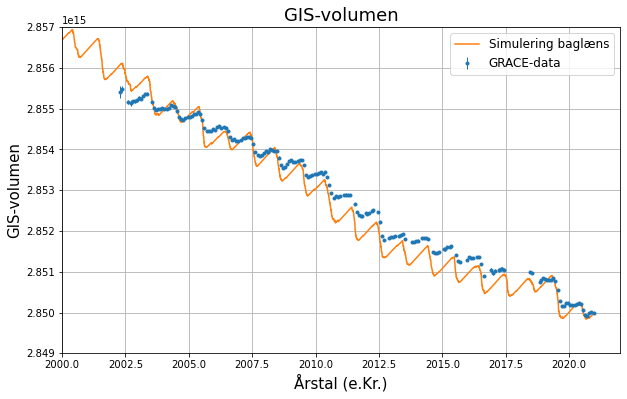

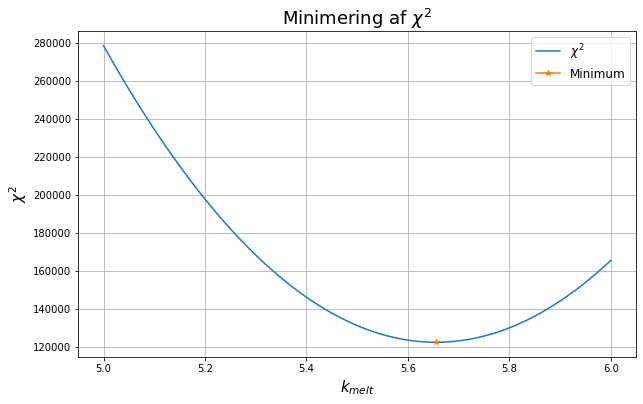

Optimal smeltekonstant: 5.655655655655655
Tilhørende chikvadrat: 1.22e+05
Wall time: 5min 29s


In [7]:
%%time
# Her bruges optimeringsfunktionen til at give os den optimale k_melt inden for et angivet interval.
konstanter_list, chi_list, k_melt, chi2  = optimering(5, 6, 1000)

plt.figure(figsize = (10,6))
plt.plot(konstanter_list, chi_list, label = r'$\chi^2$')
plt.plot(k_melt, chi2, marker = '*', label = 'Minimum')
plt.title(r'Minimering af $\chi^2$', fontsize = 18)
plt.xlabel(r'$k_{melt}$', fontsize = 15)
plt.ylabel(r'$\chi^2$', fontsize = 15)
plt.grid()
plt.legend(fontsize = 12)
plt.show()
print('Optimal smeltekonstant:', k_melt)
print('Tilhørende chikvadrat:', f'{chi2:.3}')